The good way to understand how the neural network learns a time series pattern without the extra noise and complexity of real financial data to approximate sinusoid.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

Now the Data generation, the number of points and the number of cycles to generate a sine wave.

In [ ]:
N_POINTS = 1500
N_CYCLES = 10

# The number of past time steps to use as input to predict the next time step.
SEQUENCE_LENGTH = 50
TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.15

In [ ]:
RESULTS_DIR = "sinusoid_ffnn_model_res"
EPOCHS = 25
BATCH_SIZE = 32

Generating sinusiud data, remove(comment if need for future use) noise from previous code.

In [ ]:
print("--- Generating Sinusoid Data ---")
# Create a time vector
time = np.linspace(0, N_CYCLES * 2 * np.pi, N_POINTS)
# Generate the sine wave
sin_wave = np.sin(time)

print(f"   Generated {N_POINTS} data points.")
# Return as a DataFrame
pd.DataFrame({'Value': sin_wave})

--- Generating Sinusoid Data ---
   Generated 1500 data points.


,Value
0,0.000000e+00
1,4.190357e-02
2,8.373353e-02
3,1.254164e-01
4,1.668790e-01
...,...
1495,-1.668790e-01
1496,-1.254164e-01
1497,-8.373353e-02
1498,-4.190357e-02


In [97]:
print("--- Preparing Data for FFNN ---")

# Prepare data
processed_data = sin_wave.reshape(-1, 1)

# Create sequences
X, y = [], []
for i in range(len(processed_data) - SEQUENCE_LENGTH - 100):
    X.append(processed_data[i:(i + SEQUENCE_LENGTH), 0])
    y.append(processed_data[i + SEQUENCE_LENGTH + 10, 0])
X, y = np.array(X), np.array(y)

# Define split sizes
total_samples = len(X)
train_size = 800
val_size = 200
test_size = 500

# Calculate actual available sizes
available_sizes = {
    'train': min(train_size, total_samples),
    'val': min(val_size, total_samples - train_size),
    'test': min(test_size, total_samples - train_size - val_size)
}

# Split data
X_train, y_train = X[:available_sizes['train']], y[:available_sizes['train']]
X_val, y_val = X[available_sizes['train']:available_sizes['train'] + available_sizes['val']], \
               y[available_sizes['train']:available_sizes['train'] + available_sizes['val']]
X_test, y_test = X[available_sizes['train'] + available_sizes['val']:available_sizes['train'] + available_sizes['val'] + available_sizes['test']], \
                 y[available_sizes['train'] + available_sizes['val']:available_sizes['train'] + available_sizes['val'] + available_sizes['test']]

print(f"   Training set size:   {len(X_train)} samples")
print(f"   Validation set size: {len(X_val)} samples")
print(f"   Test set size:       {len(X_test)} samples")

--- Preparing Data for FFNN ---
   Training set size:   800 samples
   Validation set size: 200 samples
   Test set size:       350 samples


In [103]:
print("--- Building, Training, and Evaluating Model ---")

model = Sequential([
  Input(shape=(SEQUENCE_LENGTH,)),
  Dense(64, activation='sigmoid'),
  Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')
model.summary()

print("\n   Training the model...")
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)

print("\n   Evaluating model performance...")
loss = model.evaluate(X_test, y_test)
print(f"   Test loss: {loss:.4f}")
predictions_actual = model.predict(X_test)

y_test_actual = y_test.reshape(-1, 1)


print("\n   Evaluating model performance...")
mae = mean_absolute_error(y_test_actual, predictions_actual)
print(f"   Mean Absolute Error (MAE): {mae:.4f}")

--- Building, Training, and Evaluating Model ---


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


   Training the model...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4405 - val_loss: 0.0060
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 7.5737e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2537e-04 - val_loss: 1.1860e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9407e-05 - val_loss: 1.9707e-05
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2019e-05 - val_loss: 4.7975e-06
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6702e-06 - val_loss: 3.6125e-06
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9888e-06 - val_loss: 3.1248e-06
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3907e-06 - val_loss: 2.7712e-06
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3548e-06 - val_loss: 2.5694e-06
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6534e-06 - val_loss: 2.1212e-06
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.334

....  Generating plot to visualize approximation...


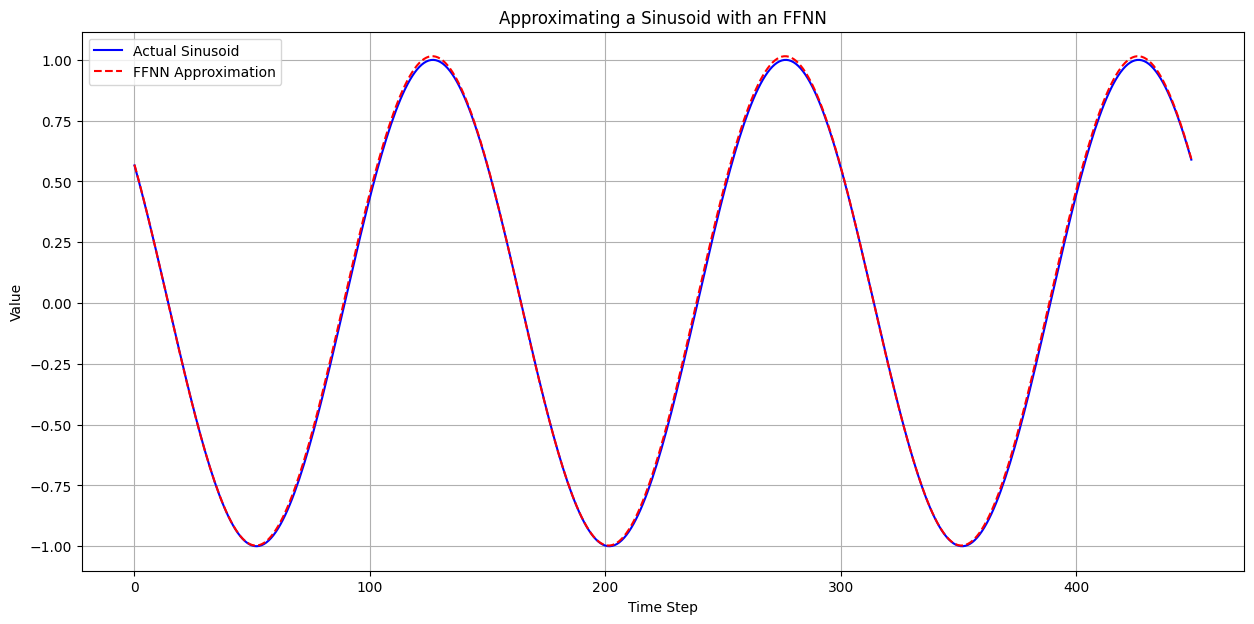

   Plot saved to 'sinusoid_ffnn_model_res/sinusoid_approximation.png'


In [ ]:
print("....  Generating plot to visualize approximation...")
os.makedirs(RESULTS_DIR, exist_ok=True)
plot_path = os.path.join(RESULTS_DIR, 'sinusoid_approximation.png')

# Create an index for the x-axis of the plot
test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test_actual))

plt.figure(figsize=(15, 7))
plt.plot(y_test_actual, color='blue', label='Actual Sinusoid')
plt.plot(predictions_actual, color='red', linestyle='--', label='FFNN Approximation')
plt.title('Approximating a Sinusoid with an FFNN')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()
print(f"   Plot saved to '{plot_path}'")

In [ ]:
print("First 5 data points of y_test_actual:")
display(y_test_actual[:5])

print("\nFirst 5 data points of predictions_actual:")
display(predictions_actual[:5])

First 5 data points of y_test_actual:


array([[0.56587357],
       [0.53082737],
       [0.49484869],
       [0.45800071],
       [0.42034817]])


First 5 data points of predictions_actual:


array([[0.56883866],
       [0.5335009 ],
       [0.4972278 ],
       [0.46007854],
       [0.42211464]], dtype=float32)

In [ ]:
print(f"Number of data points used to calculate MAE: {len(y_test_actual)}")
print(f"Number of data points used to calculate MSE: {len(predictions_actual)}")

Number of data points used to calculate MAE: 450
Number of data points used to calculate MSE: 450


In [ ]:
# Find indices where predictions_actual is close to 1
indices_at_1_pred = np.where(np.isclose(predictions_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 1:", indices_at_1_pred)

# Find indices where predictions_actual is close to 0
indices_at_0_pred = np.where(np.isclose(predictions_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 0:", indices_at_0_pred)

# Find indices where y_test_actual is close to 1
indices_at_1_actual = np.where(np.isclose(y_test_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 1:", indices_at_1_actual)

# Find indices where y_test_actual is close to 0
indices_at_0_actual = np.where(np.isclose(y_test_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 0:", indices_at_0_actual)


# Find the time step of the maximum value 1 in prediction_actual
index_of_max_actual = np.argmax(predictions_actual)
print(f"At {index_of_max_actual} timestep the max value close to 1 is {predictions_actual[index_of_max_actual]}")

Timestep where predictions_actual is close to 1: [119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434]
Timestep where predictions_actual is close to 0: [ 14  15  88  89  90 164 165 238 239 313 314 315 388 389]
Timestep where y_test_actual is close to 1: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434]
Timestep where y_test_actual is close to 0: [ 14  15  89  90 164 165 239 240 313 314 315 388 389 390]
At 426 timestep the max value close to 1 is [1.0149866]


In [ ]:
zero_values = predictions_actual[indices_at_0_pred]

# Find the index within zero_values that is closest to 0
closest_to_zero_index_in_list = np.argmin(np.abs(zero_values))

# Get the actual index from the original zero_indices list
closest_to_zero_timestep = indices_at_0_pred[closest_to_zero_index_in_list]
print(f"At {closest_to_zero_timestep} timestep the value close to 0 is {predictions_actual[closest_to_zero_timestep]}")

At 314 timestep the value close to 0 is [0.00463709]
